# Model comparison

This notebook generate more in-depth plots to look at model performance by subgroup (males over 50, etc).

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [2]:
np.random.seed(42) 

claims_data = pd.read_csv('dataset/ProcessedClaimDataLog.csv')
claims_data.drop(columns = ['AccidentType'], inplace=True)

In [24]:
# Code for soft_clustering model
class FeatureStacker(BaseEstimator, TransformerMixin):
    def __init__(self, transformers):
        self.transformers = transformers
        self.named_transformers = dict(transformers)

    def fit(self, X, y=None):
        for name, trans in self.transformers:
            trans.fit(X, y)
        return self

    def transform(self, X):
        features = [X]
        for name, trans in self.transformers:
            new_feat = trans.transform(X)
            print(f"FeatureStacker - Transformer '{name}' output shape: {new_feat.shape}")
            features.append(new_feat)
        combined_features = np.hstack(features)
        print(f"FeatureStacker - Combined features shape: {combined_features.shape}")
        return combined_features
    
# Define a custom transformer for predicting clusters and probabilities
class GMMClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, max_clusters=10, random_state=42):
        self.max_clusters = max_clusters
        self.random_state = random_state
        self.gmm = None
        self.best_k = None

    def fit(self, X, y=None):
        # Fit GMM model and determine the best number of clusters
        self.best_k, self.gmm = find_optimal_gmm_clusters(X, max_clusters=self.max_clusters, random_state=self.random_state, plot=False)
        self.n_clusters_ = self.best_k
        return self

    def transform(self, X):
        # Predict the clusters and return the cluster probabilities
        cluster_probs = self.gmm.predict_proba(X)
        return cluster_probs
    
class ClusterModelTrainerWithTuning(BaseEstimator, TransformerMixin):
    def __init__(self, models=None, param_grids=None, max_clusters=10, random_state=42, cv=10, weight_threshold_percentile=10, normalize_weights=True):
        self.best_models = {}
        self.clusterer = None
        self.cluster_performance = {}
        self.cv = cv
        self.max_clusters = max_clusters
        self.models = models or {
            'RandomForest': RandomForestRegressor(random_state=42),
            'GradientBoosting': GradientBoostingRegressor(random_state=42),
            'LinearRegression': LinearRegression(),
            'Ridge': Ridge(),
        }
        self.n_clusters = None
        self.normalize_weights = normalize_weights
        self.param_grids = param_grids or {
            'RandomForestRegressor': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5]
            },
            'GradientBoostingRegressor': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            },
            'LinearRegression': {},
            'Ridge': {
                'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
            }
        }
        self.random_state = random_state
        self.weight_threshold_percentile = weight_threshold_percentile

    def fit(self, X, y):
        best_n_clusters, self.clusterer = find_optimal_gmm_clusters(X, max_clusters=self.max_clusters, random_state=self.random_state, plot=True)
        print(f"Optimal number of clusters: {best_n_clusters}")
        self.clusterer.fit(X)
        cluster_probs = self.clusterer.predict_proba(X)
        self.n_clusters = best_n_clusters

        for cluster_idx in range(self.n_clusters):
            raw_weights = cluster_probs[:, cluster_idx].copy()
            
            # Determine dynamic threshold
            threshold = np.percentile(raw_weights, self.weight_threshold_percentile)
            weights = np.where(raw_weights >= threshold, raw_weights, 0)

            # Normalize weights if enabled
            if self.normalize_weights and weights.sum() > 0:
                weights /= weights.sum()
                weights *= len(weights)  # keep mean weight ~1

            if np.count_nonzero(weights) < 2:
                print(f"Cluster {cluster_idx} has too few weighted samples after thresholding.")
                continue

            best_score = -np.inf
            best_model = None

            for model_name, model in self.models.items():
                candidate = clone(model)
                param_grid = self.param_grids.get(model_name, {})

                grid_search = GridSearchCV(
                    estimator=candidate,
                    param_grid=param_grid,
                    cv=self.cv,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=1,
                    error_score=np.nan
                )
                try:
                    grid_search.fit(X, y, sample_weight=weights)
                    mean_score = grid_search.best_score_
                except ValueError:
                    # Some models may not support sample_weight in CV - fallback to fitting directly
                    candidate.fit(X, y, sample_weight=weights)
                    mean_score = -np.mean((candidate.predict(X) - y) ** 2)

                if mean_score > best_score:
                    best_score = mean_score
                    best_model = grid_search.best_estimator_

            if best_model is None:
                print(f"No valid model found for cluster {cluster_idx}.")
                continue

            print(f"Cluster {cluster_idx}: Best model is {best_model.__class__.__name__} with CV MAE {best_score:.2f}")
            best_model.fit(X, y, sample_weight=weights)
            self.best_models[cluster_idx] = best_model
            self.cluster_performance[cluster_idx] = {
                'model': best_model,
                'cv_mae': -best_score,  # scoring = 'neg_mean_absolute_error'
                'size': cluster_probs[:, cluster_idx].sum()
            }

        return self

In [3]:
def identify_columns(claims_data):

    # Identify categorical and numerical columns
    categorical_cols = claims_data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = claims_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Remove the target variable from the feature lists
    target_col = 'LogSettlementValue'

    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    if 'SettlementValue' in numerical_cols: 
        numerical_cols.remove('SettlementValue') 

    print(f"\nCategorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    print(f"Target column: {target_col}")

    return categorical_cols, numerical_cols, target_col

# Update categorical and numerical columns based on the transformed dataset
def define_preprocessor(X_train):
    categorical_cols, numerical_cols, _ = identify_columns(claims_data=claims_data)

    categorical_cols = [col for col in categorical_cols if col in X_train.columns]
    numerical_cols = [col for col in numerical_cols if col in X_train.columns]

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])

    return preprocessor

# Function to evaluate a model
def evaluate_model(model, X, y, model_name, log_transform=True):
    y_pred = model.predict(X)
    
    # Calculate metrics on log scale
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Calculate metrics on original GBP scale
    if log_transform:
        y_pounds = np.expm1(y)
        y_pred_pounds = np.expm1(y_pred)
        mse_pounds = mean_squared_error(y_pounds, y_pred_pounds)
        rmse_pounds = np.sqrt(mse_pounds)
        mae_pounds = mean_absolute_error(y_pounds, y_pred_pounds)
    else:
        y_pounds = y
        y_pred_pounds = y_pred
        mse_pounds = mse
        rmse_pounds = rmse
        mae_pounds = mae
    
    return {
        'MSE': mse_pounds,
        'RMSE': rmse_pounds,
        'MAE': mae_pounds,
        'R^2': r2,
        'Name': model_name,
        'y_pred': y_pred
        # 'MSE_GBP': mse_pounds,
        # 'RMSE_GBP': rmse_pounds,
        # 'MAE_GBP': mae_pounds,
        # 'y_pred': y_pred,
        # 'y_pred_GBP': y_pred_pounds
    }

In [4]:
if 'AccidentDate' in claims_data.columns and 'ClaimDate' in claims_data.columns:
    claims_data['DaysBetweenAccidentAndClaim'] = claims_data['ClaimDate'] - claims_data['AccidentDate']

categorical_cols, numerical_cols, target_col = identify_columns(claims_data=claims_data)


Categorical columns: ['DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue


In [5]:
# Splitting data
X = claims_data.drop(columns=[target_col])
y = claims_data[target_col]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 2577 samples
Validation set size: 860 samples
Test set size: 860 samples


In [6]:
subgroups = {
    'Males under 30': (X_val['Gender'] == 'Male') & (X_val['DriverAge'] < 30),
    'Females under 30': (X_val['Gender'] == 'Female') & (X_val['DriverAge'] < 30),
    'Other under 30': (X_val['Gender'] == 'Other') & (X_val['DriverAge'] < 30),
    'Males over 50': (X_val['Gender'] == 'Male') & (X_val['DriverAge'] > 50),
    'Females over 50': (X_val['Gender'] == 'Female') & (X_val['DriverAge'] > 50),
    'Other over 50': (X_val['Gender'] == 'Other') & (X_val['DriverAge'] > 50),
    # '3+ Passengers': (X_val['NumberOfPassengers'] >= 3),
    # 'Whiplash': (X_val['Whiplash'] == 1),
}

def evaluate_all_models_by_subgroup(model_results, X_val, y_val, subgroups):
    metrics = []

    for model_name, result in model_results.items():
        pipeline = result.get('pipeline')
        if not pipeline:
            continue

        for group_name, condition in subgroups.items():
            X_group = X_val[condition]
            y_group = y_val[condition]

            if len(X_group) == 0:
                continue

            y_pred = pipeline.predict(X_group)
            y_pounds = np.expm1(y_group)
            y_pred_pounds = np.expm1(y_pred)
            mse_pounds = mean_squared_error(y_pounds, y_pred_pounds)
            rmse_pounds = np.sqrt(mse_pounds)
            mae_pounds = mean_absolute_error(y_pounds, y_pred_pounds)

            metrics.append({
                'Model': model_name,
                'Group': group_name,
                'MAE': mae_pounds,
                'MSE': mse_pounds,
                'RMSE': rmse_pounds,
                'Count': len(X_group)
            })

    return pd.DataFrame(metrics)

In [7]:
def get_model_prediction_errors(model_results, X_val, y_val, exclude_models=None):
    """
    Returns a DataFrame showing prediction errors (MSE, MAE) per observation for each model.
    """
    error_dfs = []

    for model_name, result in model_results.items():
        pipeline = result.get('pipeline')
        if not pipeline:
            continue

        y_pred = pipeline.predict(X_val)

        # Convert back to pounds
        y_true_pounds = np.expm1(y_val)
        y_pred_pounds = np.expm1(y_pred)

        squared_errors = (y_true_pounds - y_pred_pounds) ** 2
        abs_errors = np.abs(y_true_pounds - y_pred_pounds)

        df = pd.DataFrame({
            'Model': model_name,
            'Actual': y_true_pounds,
            'Predicted': y_pred_pounds,
            'SquaredError': squared_errors,
            'AbsoluteError': abs_errors
        }, index = y_val.index)

        error_dfs.append(df)

    return pd.concat(error_dfs)

def top_n_errors_by_model(error_df, n=5):
    """
    Returns the top N predictions with the highest MSE per model.
    """
    return error_df.sort_values('SquaredError', ascending=False).groupby('Model').head(n)

In [8]:
def plot_all_model_predictions(model_results, X_val, y_val, exclude_models=None):
    """
    Plots predicted vs. actual settlement values for each model, excluding specified models.
    """
    if exclude_models is None:
        exclude_models = []

    # Filter out models
    filtered_results = {k: v for k, v in model_results.items() if k not in exclude_models}

    num_models = len(filtered_results)
    ncols = 3
    nrows = int(np.ceil(num_models / ncols))

    plt.figure(figsize=(ncols * 5, nrows * 4))

    for idx, (model_name, result) in enumerate(filtered_results.items()):
        pipeline = result.get('pipeline')
        if not pipeline:
            continue

        y_pred = pipeline.predict(X_val)

        y_true_gbp = np.expm1(y_val)
        y_pred_gbp = np.expm1(y_pred)

        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(y_true_gbp, y_pred_gbp, alpha=0.5, s=10)
        plt.plot([y_true_gbp.min(), y_true_gbp.max()], [y_true_gbp.min(), y_true_gbp.max()], 'r--')
        plt.title(model_name)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")

    plt.tight_layout()
    plt.suptitle("Actual vs Predicted Settlement Values by Model", fontsize=16, y=1.02)
    plt.show()


In [9]:
def execute_pipeline(models, preprocesser, X_train_data=None):
    # Dictionary to store model results
    model_results = {}
    print("\nTraining and evaluating models:")

    for name, model in models.items():
        start_time = time.time()
        
        # Create pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocesser),
            ('model', model)
        ])
        
        # Train the model
        print(f"Training {name}...")
        
        # check if data is passed in, else use pre-defined X_train
        if(X_train_data is None):
            pipeline.fit(X_train, y_train)
        else:
            print("GOT HERE")
            pipeline.fit(X_train_data, y_train)
        
        # Evaluate on validation set
        results = evaluate_model(pipeline, X_val, y_val, name)
        results['Training Time'] = time.time() - start_time
        model_results[name] = results
        
        # print(f"  {name} - RMSE: {results['RMSE']:.2f}, R^2: {results['R^2']:.4f}, Time: {results['Training Time']:.2f}s")
        print(f"  Error in GBP - RMSE: {results['RMSE']:.2f}, MSE: £{results['MSE']:.2f}, MAE: £{results['MAE']:.2f}")
        
        # Store the pipeline
        model_results[name]['pipeline'] = pipeline

    # using RSMe to compare the models
    best_model_name = min(model_results, key=lambda k: model_results[k]['RMSE'])
    print(f"\nBest model based on validation RMSE: {best_model_name}")
    best_pipeline = model_results[best_model_name]['pipeline']

    return best_model_name, best_pipeline, model_results

from sklearn.model_selection import GridSearchCV

def fine_tune_top_models(top_models, model_results, param_grids, preprocessor, X_train, y_train, X_val, y_val):
    tuned_models = {}

    for model_name, result in top_models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', result['pipeline'].named_steps['model'])  # use same model instance
        ])

        if model_name not in param_grids:
            print(f"⚠️ No param grid for {model_name}, skipping.")
            continue

        print(f"\n🔍 Tuning {model_name}...")
        grid = GridSearchCV(
            pipeline,
            param_grids[model_name],
            scoring='neg_root_mean_squared_error',
            cv=5,
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X_train, y_train)

        print(f"✅ Best parameters for {model_name}: {grid.best_params_}")
        tuned_model = grid.best_estimator_

        # Re-evaluate on validation set
        tuned_results = evaluate_model(tuned_model, X_val, y_val, f"{model_name} (Tuned)")
        tuned_results['pipeline'] = tuned_model
        model_results[f"{model_name} (Tuned)"] = tuned_results
        tuned_models[model_name] = tuned_results

    return tuned_models


In [10]:
# Define a list of models to try
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

preprocessor = define_preprocessor(claims_data)

best_model_name, best_pipeline, model_results = execute_pipeline(models=models, preprocesser=preprocessor)


Categorical columns: ['DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue

Training and evaluating models:
Training LinearRegression...
  Error in GBP - RMSE: 176174.37, MSE: £31037407745.90, MAE: £6286.96
Training Ridge...
  Error in GBP - RMSE: 27695.66, MSE: £767049485.48, MAE: £1223.45
Training 

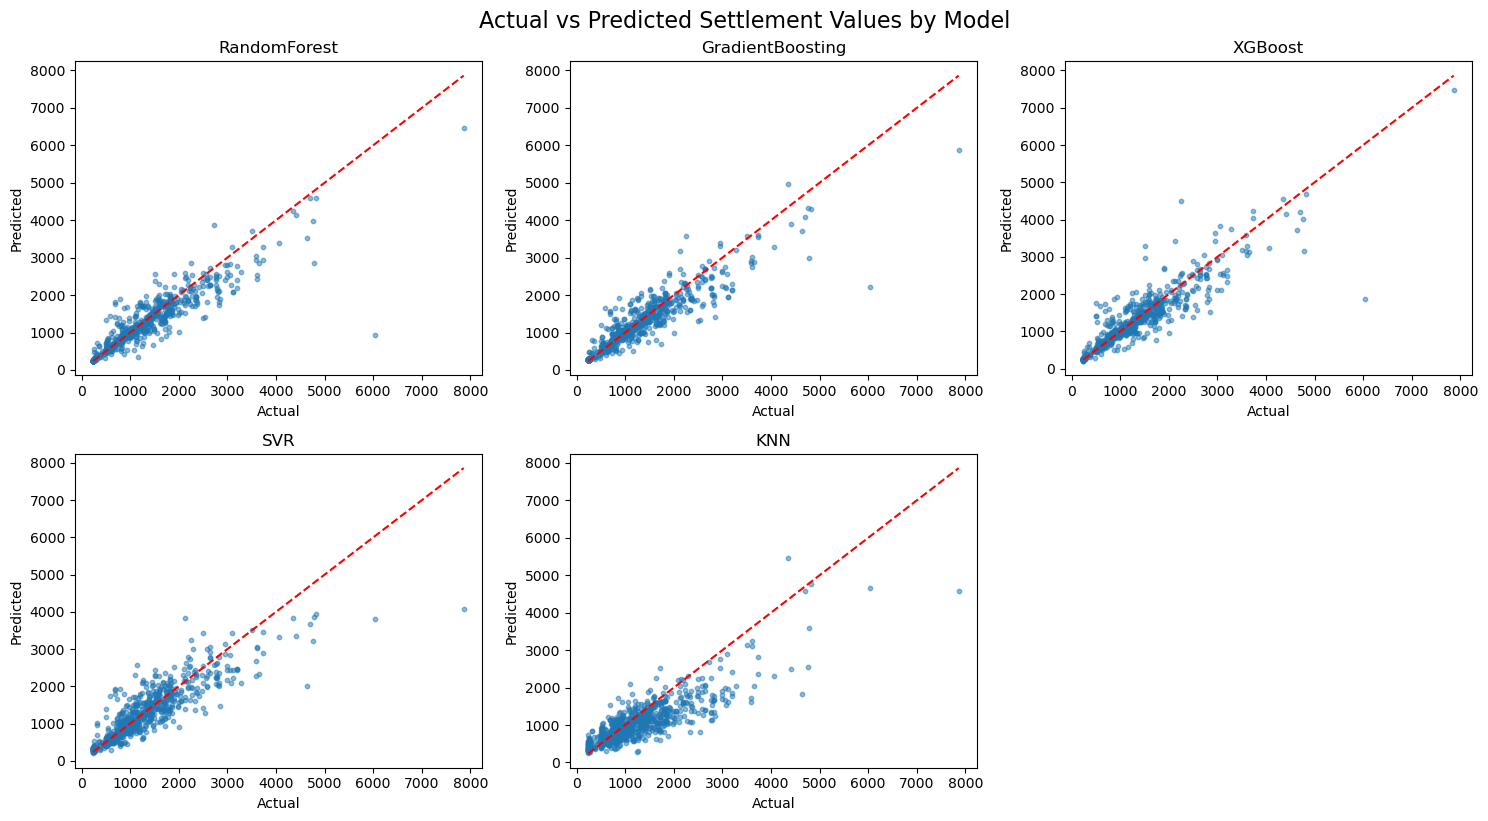

In [11]:
plot_all_model_predictions(model_results, X_val, y_val, exclude_models=['LinearRegression', 'Ridge'])

In [12]:
def predicted_settlement_plot(y_pred_test, y_test, best_model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(np.expm1(y_test), np.expm1(y_pred_test), alpha=0.5)
    plt.plot([np.expm1(y_test.min()), np.expm1(y_test.max())], [np.expm1(y_test.min()), np.expm1(y_test.max())], 'r--')
    plt.xlabel('Actual Settlement Values')
    plt.ylabel('Predicted Settlement Values')
    plt.title(f'Actual vs. Predicted Settlement Values ({best_model_name})')
    plt.tight_layout()
    plt.show()

def residual_plot(y_test, y_pred_test):
    # Calculate residuals
    residuals = y_test - y_pred_test

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Settlement Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()
    plt.show()

In [13]:
def important_features_calc(best_pipeline):
    # Get feature names after preprocessing
    if categorical_cols:
        # Get feature names from the preprocessor
        preprocessor = best_pipeline.named_steps['preprocessor']
        feature_names = []
        
        # Get numerical feature names
        if numerical_cols:
            feature_names.extend(numerical_cols)
        
        # Get one-hot encoded feature names
        if categorical_cols:
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            # Get category names from one-hot encoder
            cat_features = ohe.get_feature_names_out(categorical_cols)
            feature_names.extend(cat_features)
    else:
        feature_names = numerical_cols

    # For tree-based models, we can get feature importance directly
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        importances = best_pipeline.named_steps['model'].feature_importances_
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title(f'Top 20 Feature Importances ({best_model_name})')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 important features:")
        print(feature_imp.head(10))
    else:
        # For linear models, use coefficients
        if hasattr(best_pipeline.named_steps['model'], 'coef_'):
            coefs = best_pipeline.named_steps['model'].coef_
            
            if coefs.ndim == 1:  # For models with a 1D coefficient array
                feature_imp = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coefs
                }).sort_values('Coefficient', key=abs, ascending=False)
                
                # Plot coefficient values
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Coefficient', y='Feature', data=feature_imp.head(20))
                plt.title(f'Top 20 Feature Coefficients ({best_model_name})')
                plt.tight_layout()
                plt.show()
                
                print("\nTop 10 features by coefficient magnitude:")
                print(feature_imp.head(10))
        else:
            # Permutation importance for models without built-in feature importance
            print("\nCalculating permutation importance...")
            perm_importance = permutation_importance(
                best_pipeline, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
            )
            
            feature_imp = pd.DataFrame({
                'Feature': feature_names,
                'Importance': perm_importance.importances_mean
            }).sort_values('Importance', ascending=False)

    return feature_imp

def permutation_importance_plotting(feature_imp):
    # Plot permutation importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
    plt.title(f'Top 20 Permutation Importances ({best_model_name})')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features by permutation importance:")
    print(feature_imp.head(10))

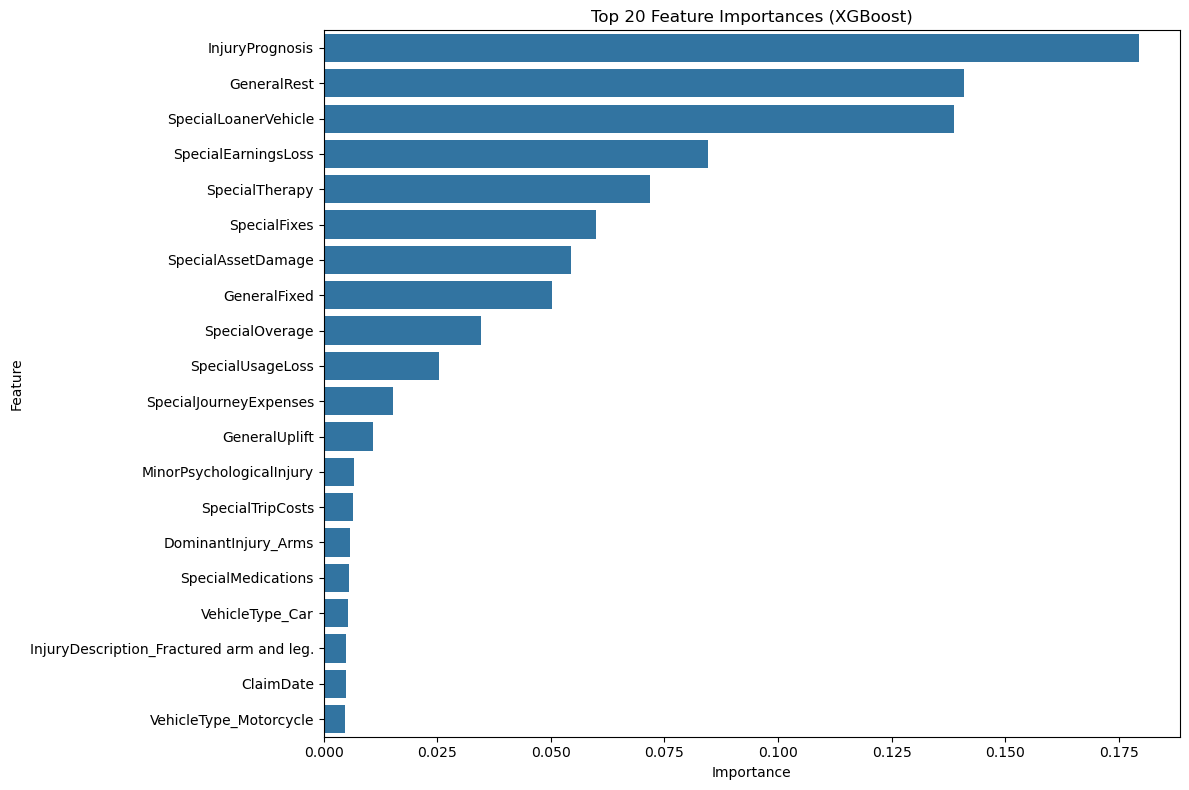


Top 10 important features:
                 Feature  Importance
0        InjuryPrognosis    0.179465
4            GeneralRest    0.140994
14  SpecialLoanerVehicle    0.138620
6    SpecialEarningsLoss    0.084530
17        SpecialTherapy    0.071852
11          SpecialFixes    0.059861
9     SpecialAssetDamage    0.054397
12          GeneralFixed    0.050228
3         SpecialOverage    0.034693
7       SpecialUsageLoss    0.025346


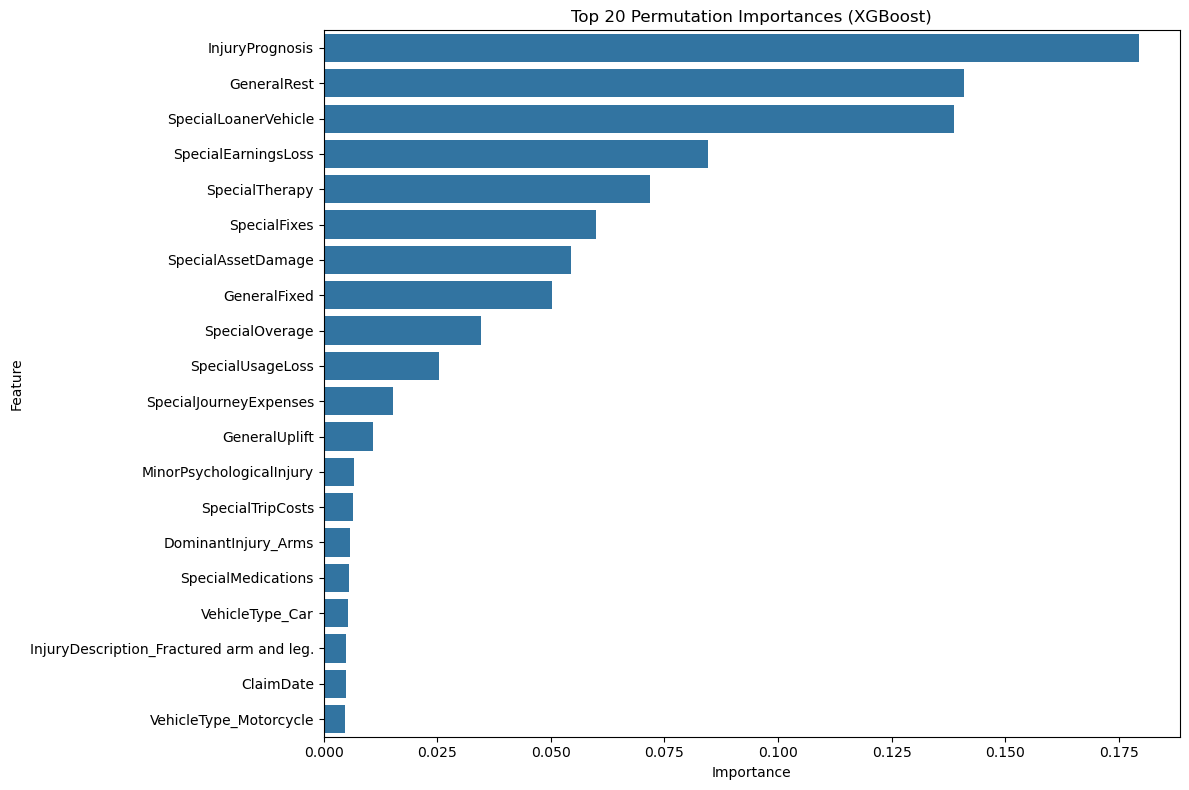


Top 10 features by permutation importance:
                 Feature  Importance
0        InjuryPrognosis    0.179465
4            GeneralRest    0.140994
14  SpecialLoanerVehicle    0.138620
6    SpecialEarningsLoss    0.084530
17        SpecialTherapy    0.071852
11          SpecialFixes    0.059861
9     SpecialAssetDamage    0.054397
12          GeneralFixed    0.050228
3         SpecialOverage    0.034693
7       SpecialUsageLoss    0.025346


In [14]:
feature_imp = important_features_calc(best_pipeline=best_pipeline)
permutation_importance_plotting(feature_imp=feature_imp)

In [15]:
def gender_bias_plot(X_test_with_preds):
    # Check for biases in predictions by protected characteristics
    if 'Gender' in X_test.columns:
        # Calculate average error by gender
        gender_errors = X_test_with_preds.groupby('Gender')['Error'].mean()
        
        print("\nAverage prediction error by gender:")
        print(gender_errors)

        # Plot gender error comparison
        plt.figure(figsize=(10, 6))
        gender_errors.plot(kind='bar')
        plt.title('Average Prediction Error by Gender')
        plt.ylabel('Mean Absolute Error')
        plt.tight_layout()
        plt.show()
    else:
        print("Gender Column not found!")
    
def age_bias_plot(X_test_with_preds):
    # Check for biases by age
    if 'DriverAge' in X_test.columns:
        # Create age groups
        X_test_with_preds['AgeGroup'] = pd.cut(X_test_with_preds['DriverAge'], 
                                            bins=[0, 30, 40, 50, 60, 70, 80],
                                            labels=['Under 30', '30-40', '40-50', '50-60', '60-70', '70-80'])
        
        # Calculate average error by age group
        age_group_errors = X_test_with_preds.groupby('AgeGroup', observed=False)['Error'].mean()

        print("\nAverage prediction error by age group:")
        print(age_group_errors)

        # Plot age group error comparison
        plt.figure(figsize=(12, 6))
        age_group_errors.plot(kind='bar')
        plt.title('Average Prediction Error by Age Group')
        plt.ylabel('Mean Absolute Error')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Age Column not found")

def bias_helper(X_test, y_test, y_pred_test):
    # Add predictions to test data
    X_test_with_preds = X_test.copy()
    X_test_with_preds['Predicted'] = y_pred_test
    X_test_with_preds['Actual'] = y_test.values
    X_test_with_preds['Error'] = abs(y_test.values - y_pred_test)

    return X_test_with_preds


In [16]:
X_test_with_preds = bias_helper(X_test=X_test, y_test=np.expm1(y_test), y_pred_test=np.expm1(y_pred_test))

age_bias_plot(X_test_with_preds=X_test_with_preds)
gender_bias_plot(X_test_with_preds=X_test_with_preds)

NameError: name 'y_pred_test' is not defined

## Tune models with top 10 features

In [30]:
top_10 = list(feature_imp.head(10)['Feature'])

X_train_filtered = X_train[top_10]
X_val_filtered = X_val[top_10]
X_test_filtered = X_test[top_10]

preprocessor = define_preprocessor(X_train_filtered)

# with open('soft_clustering.pkl', 'rb') as f:
#     gmm_cluster_model = pickle.load(f)
    
# for key in gmm_cluster_model:
#     print(f"{key}: {type(gmm_cluster_model[key])}")    

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
    # 'GMM': gmm_cluster_model
}


Categorical columns: ['DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue


In [31]:
# Check that all features have transferred over
missing_columns = set(top_10) - set(X_train_filtered.columns)
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All top 10 features are present in the filtered dataset.")

All top 10 features are present in the filtered dataset.


In [32]:
best_model_name, best_pipeline, model_results = execute_pipeline(models=models, preprocesser=preprocessor, X_train_data=X_train_filtered)

param_grids = {
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
    },
    'GradientBoosting': {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__max_depth': [3, 6, 9],
    },
    'XGBoost': {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__max_depth': [3, 6, 9],
        'model__subsample': [0.8, 1.0]
    },
    'SVR': {
        'model__C': [0.1, 1, 10, 100],  
        'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'model__kernel': ['rbf']
    } 
}
# print(models['SVR'].get_params().keys())
# best_pipeline, param_grid, model_results = model_tuner(best_pipeline, param_grid, model_results)
top_3_models = sorted(model_results.items(), key=lambda x: x[1]['RMSE'])[:3]

tuned_models = fine_tune_top_models(
    top_3_models,
    model_results,
    param_grids,
    preprocessor,
    X_train_filtered,
    y_train,
    X_val_filtered,
    y_val
)


Training and evaluating models:
Training LinearRegression...
GOT HERE
  Error in GBP - RMSE: 598.50, MSE: £358200.23, MAE: £282.73
Training Ridge...
GOT HERE
  Error in GBP - RMSE: 598.36, MSE: £358033.94, MAE: £282.68
Training RandomForest...
GOT HERE
  Error in GBP - RMSE: 308.21, MSE: £94991.19, MAE: £119.07
Training GradientBoosting...
GOT HERE
  Error in GBP - RMSE: 330.80, MSE: £109430.99, MAE: £181.47
Training XGBoost...
GOT HERE
  Error in GBP - RMSE: 298.86, MSE: £89317.81, MAE: £117.98
Training SVR...
GOT HERE
  Error in GBP - RMSE: 316.05, MSE: £99886.98, MAE: £188.61
Training KNN...
GOT HERE
  Error in GBP - RMSE: 334.74, MSE: £112052.41, MAE: £171.49

Best model based on validation RMSE: XGBoost

🔍 Tuning XGBoost...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
✅ Best parameters for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 200, 'model__subsample': 1.0}

🔍 Tuning RandomForest...
Fitting 5 folds for each of 18 cand

In [34]:
# Evaluate the best model on the test set
best_pipeline = model_results[best_model_name]['pipeline']
test_results = evaluate_model(best_pipeline, X_test_filtered, y_test, best_model_name)
print(f"\nTest set evaluation for {best_model_name}:")
print(f"  RMSE: {test_results['RMSE']:.2f}")
print(f"  MSE: {test_results['MSE']:.2f}")
print(f"  MAE: {test_results['MAE']:.2f}")
print(f"  R^2: {test_results['R^2']:.4f}")


Test set evaluation for XGBoost:
  RMSE: 231.50
  MSE: 53590.72
  MAE: 99.68
  R^2: 0.9447


In [44]:
best_model_filename = 'limited_model.pkl'
print(f"Saving best model ({best_model_name}) to {best_model_filename}")

with open(best_model_filename, 'wb') as file:
    pickle.dump(best_pipeline, file)
    
print("Model saved successfully!")

Saving best model (XGBoost) to limited_model.pkl
Model saved successfully!


## Plots

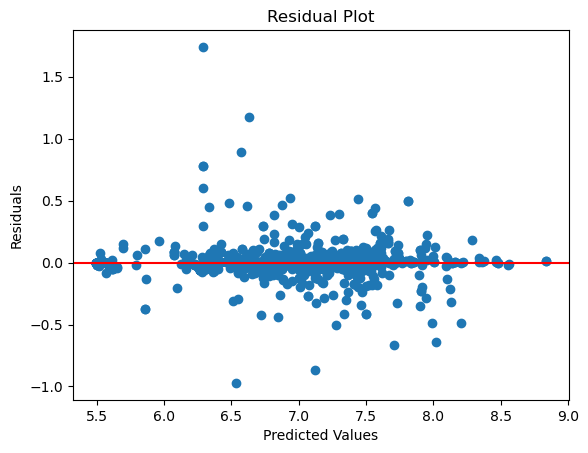

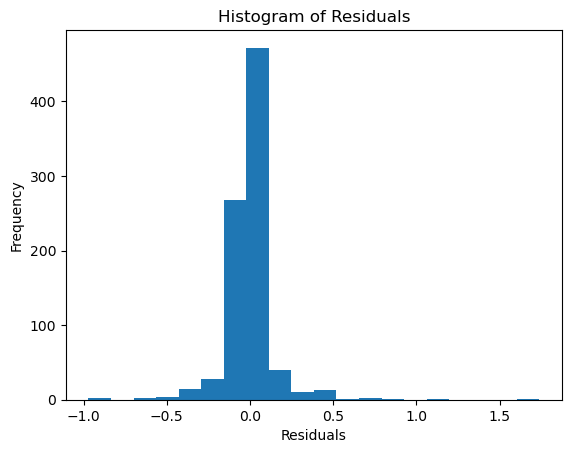

In [35]:
residuals = y_test - test_results['y_pred']

plt.scatter(test_results['y_pred'], residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.show()

# Plot residuals vs predicted values
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

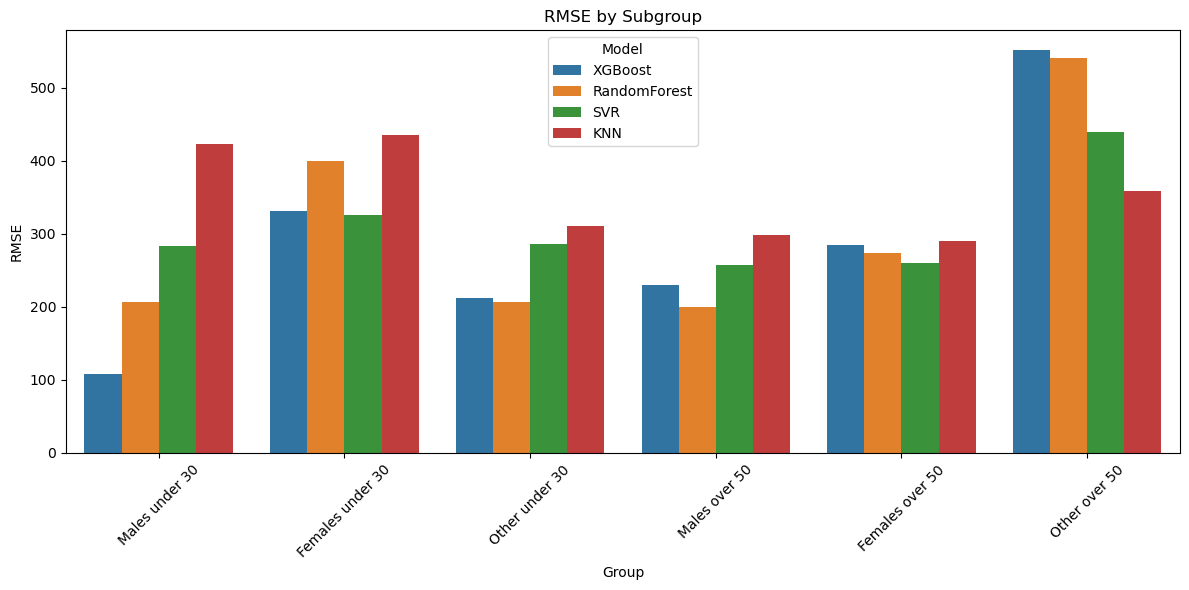

In [36]:
tuned_models['KNN'] = model_results['KNN']
df_subgroup_comparison = evaluate_all_models_by_subgroup(tuned_models, X_val_filtered, y_val, subgroups)
filtered_df = df_subgroup_comparison[
    ~df_subgroup_comparison['Model'].isin(['LinearRegression', 'Ridge'])
]
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df, x='Group', y='RMSE', hue='Model')
plt.title("RMSE by Subgroup")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Other over 50 has a reasonably higher error rate across models. 
Look into this below:

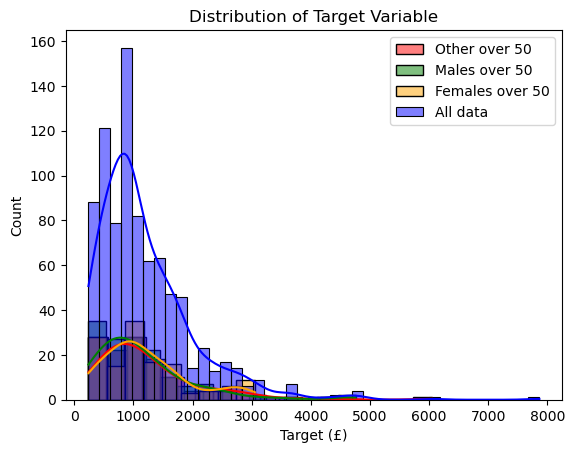

In [40]:
sns.histplot(np.expm1(y_val[subgroups['Other over 50']]), kde=True, color='red', label='Other over 50')
sns.histplot(np.expm1(y_val[subgroups['Males over 50']]), kde=True, color='green', label='Males over 50')
sns.histplot(np.expm1(y_val[subgroups['Females over 50']]), kde=True, color='orange', label='Females over 50')
sns.histplot(np.expm1(y_val), kde=True, color='blue', label='All data', alpha=0.5)
plt.legend()
plt.title('Distribution of Target Variable')
plt.xlabel('Target (£)')
plt.show()

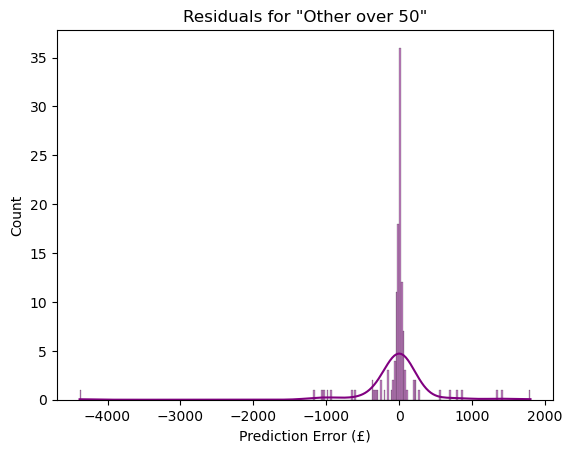

In [42]:
# Calculate residuals (log-space if needed)
residuals = np.expm1(best_pipeline.predict(X_val_filtered[subgroups['Other over 50']])) - np.expm1(y_val[subgroups['Other over 50']])
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals for "Other over 50"')
plt.xlabel('Prediction Error (£)')
plt.show()

In [43]:
error_df = get_model_prediction_errors(tuned_models, X_val_filtered, y_val)
filtered_error_df = error_df[
    ~error_df['Model'].isin(['LinearRegression', 'Ridge'])
]
top_errors = top_n_errors_by_model(filtered_error_df, n=5)
print(top_errors)

             Model   Actual    Predicted  SquaredError  AbsoluteError
1083  RandomForest  6047.08  1035.288507  2.511805e+07    5011.791493
1083       XGBoost  6047.08  1149.710449  2.398423e+07    4897.369551
2171           KNN  4635.20  1856.030234  7.723785e+06    2779.169766
3453           KNN  7862.90  5129.971523  7.468898e+06    2732.928477
2171           SVR  4635.20  2313.090015  5.392195e+06    2322.109985
1083           SVR  6047.08  3927.623885  4.492094e+06    2119.456115
3623           KNN  4755.00  2699.057209  4.226901e+06    2055.942791
1929           SVR  2249.99  4199.784229  3.801698e+06    1949.794229
638            KNN  2540.00   919.445897  2.626196e+06    1620.554103
1923  RandomForest  1597.00  3209.267756  2.599407e+06    1612.267756
3009  RandomForest  1597.00  3209.267756  2.599407e+06    1612.267756
3009       XGBoost  1597.00  3141.633301  2.385892e+06    1544.633301
1923       XGBoost  1597.00  3141.633301  2.385892e+06    1544.633301
3009           KNN  

## Look at problematic row 1083...

      InjuryPrognosis  GeneralRest  SpecialLoanerVehicle  SpecialEarningsLoss  \
1083                5        500.0                   0.0              5027.08   

      SpecialTherapy  SpecialFixes  SpecialAssetDamage  GeneralFixed  \
1083             0.0           0.0                 0.0         520.0   

      SpecialOverage  SpecialUsageLoss  
1083             0.0               0.0  


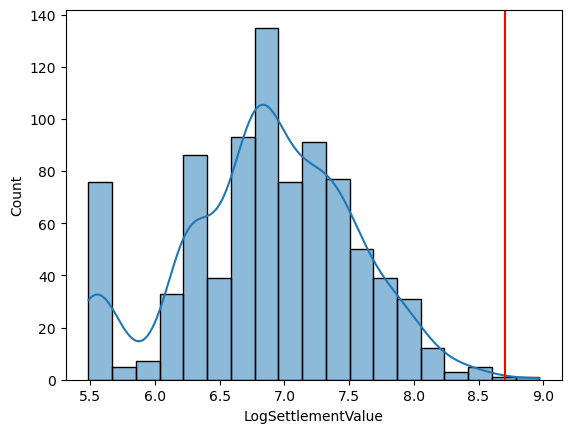

In [33]:
print(X_val_filtered.loc[[1083]])
np.expm1(y_val.loc[[1083]])

sns.histplot(y_val, kde=True)
plt.axvline(y_val.loc[1083], color='red')

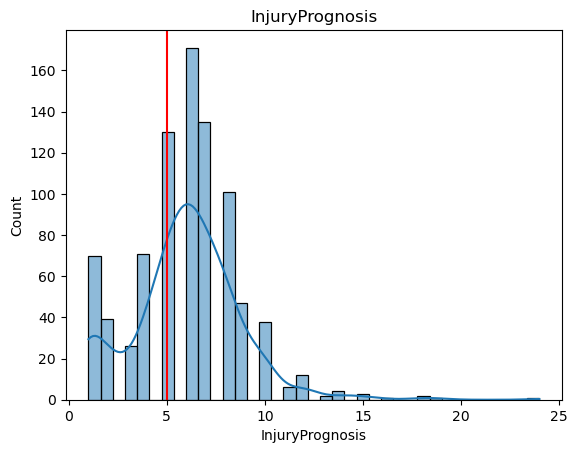

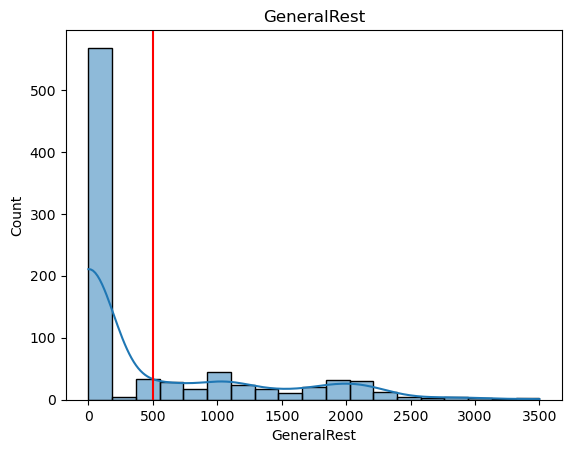

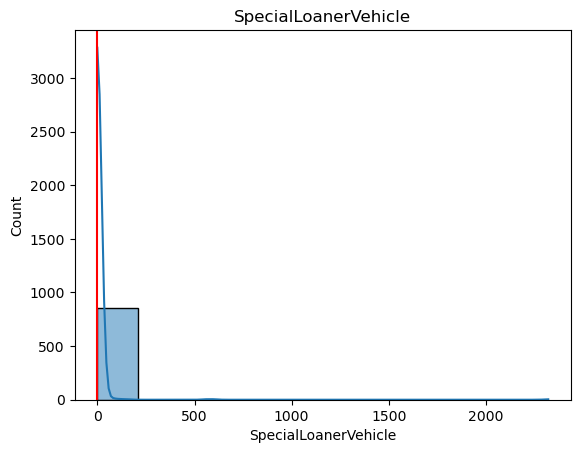

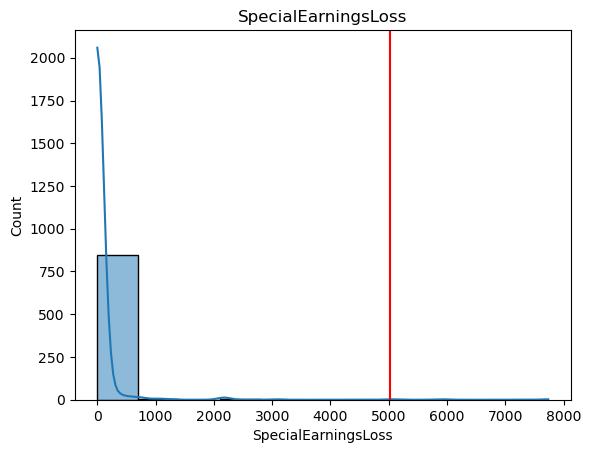

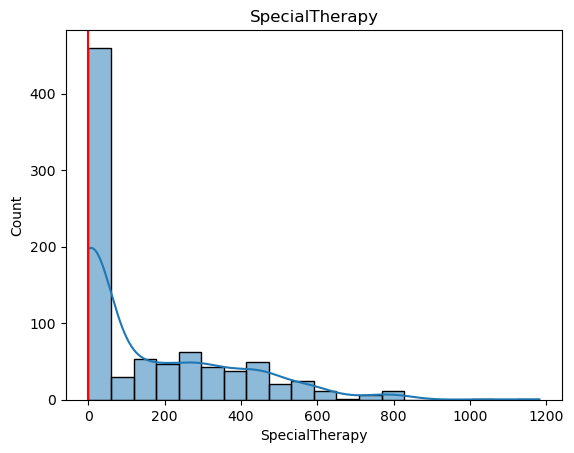

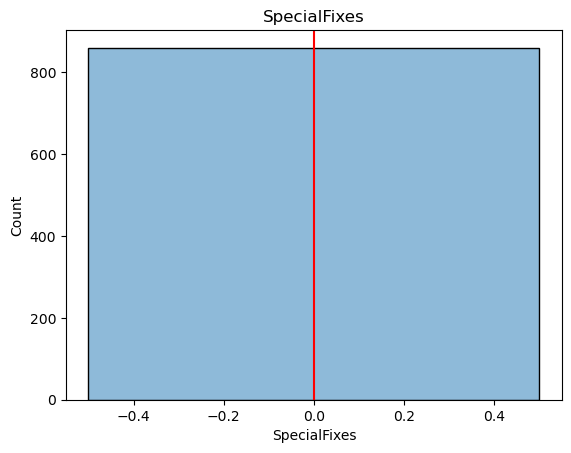

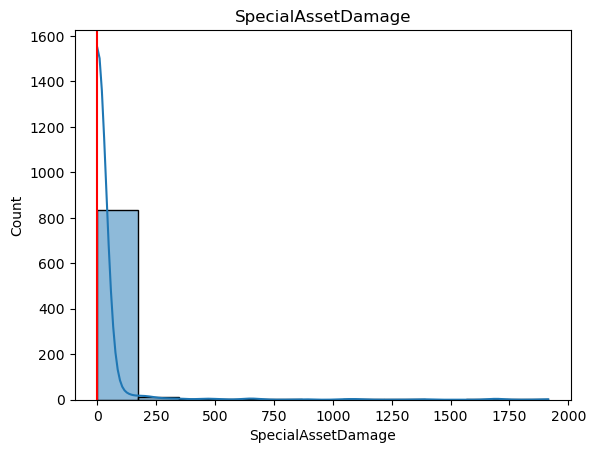

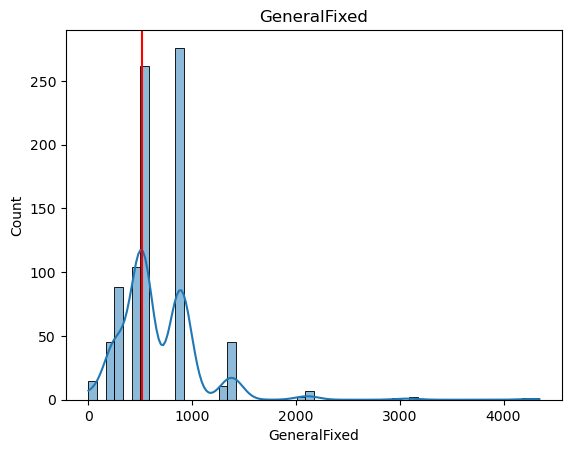

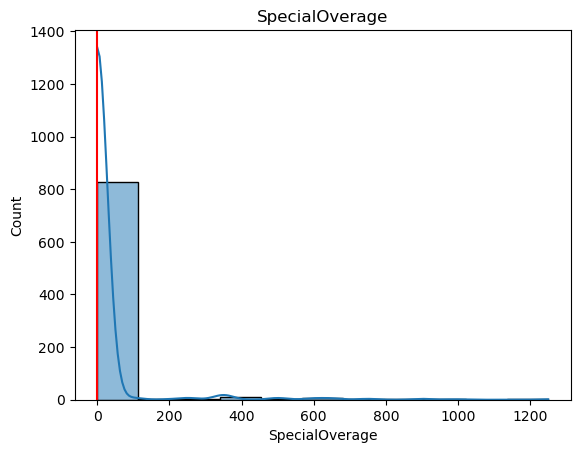

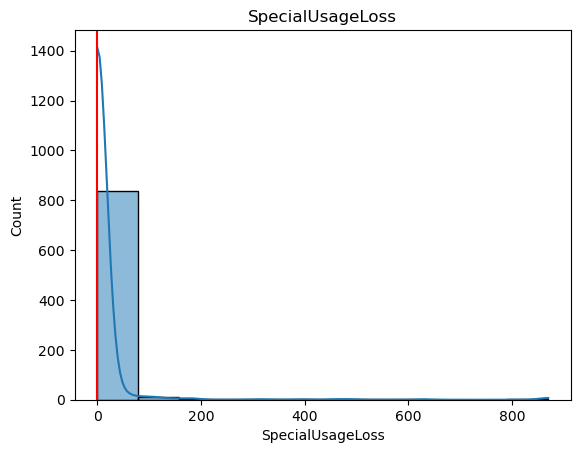

In [34]:
for col in X_val_filtered.select_dtypes(include='number').columns:
    sns.histplot(X_val_filtered[col], kde=True)
    plt.axvline(X_val_filtered.loc[1083, col], color='red')  # problematic row's value
    plt.title(col)
    plt.show()

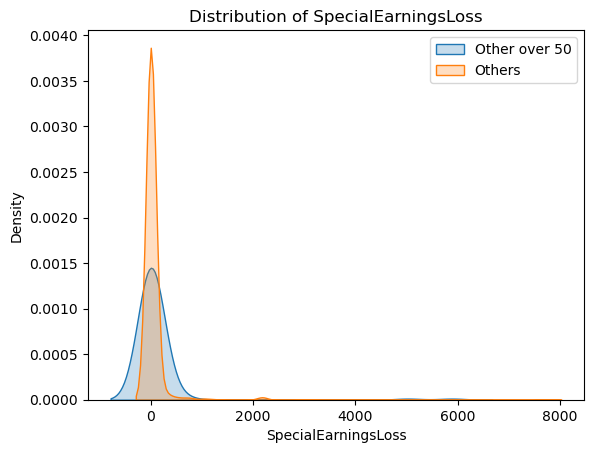

In [45]:
sns.kdeplot(X_val_filtered[subgroups['Other over 50']]['SpecialEarningsLoss'], label='Other over 50', fill=True)
sns.kdeplot(X_val[~subgroups['Other over 50']]['SpecialEarningsLoss'], label='Others', fill=True)
plt.title(f'Distribution of SpecialEarningsLoss')
plt.legend()
plt.show()

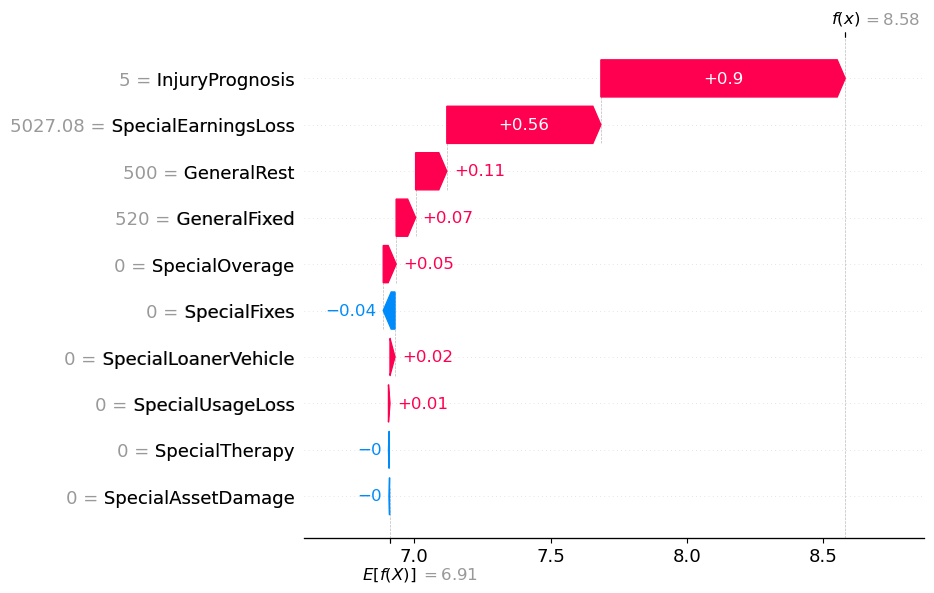

In [33]:
import shap

explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])
shap_values = explainer(X_val_filtered)

row_position = X_val_filtered.index.get_loc(1083)
shap.plots.waterfall(shap_values[row_position])

Things to consider:
- Both SpecialEarningsLoss and LogSettlementValue are very high compared to the distribution of data
- SHAP shows SpecialEarningsLoss particularly has a high impact on this